In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# For modeling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
sns.set_theme(style='whitegrid')
pd.options.mode.chained_assignment = None  # Supress warning, default='warn'

# Read Data

In [2]:
df = pd.read_csv('../data/preprocessed/accepted_2007_to_2018Q4_preprocessed.csv')
print(f"Shape of df: {df.shape}")
df.head(5)

Shape of df: (1345310, 101)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,3600.0,3600.0,3600.0,36,13.99,123.03,C,C4,10.0,MORTGAGE,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,24700.0,24700.0,24700.0,36,11.99,820.28,C,C1,10.0,MORTGAGE,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,20000.0,20000.0,20000.0,60,10.78,432.66,B,B4,10.0,MORTGAGE,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,10400.0,10400.0,10400.0,60,22.45,289.91,F,F1,3.0,MORTGAGE,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N
4,11950.0,11950.0,11950.0,36,13.44,405.18,C,C3,4.0,RENT,...,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,N,Cash,N


In [3]:
df.dtypes

loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
term                            int64
int_rate                      float64
                               ...   
total_bc_limit                float64
total_il_high_credit_limit    float64
hardship_flag                  object
disbursement_method            object
debt_settlement_flag           object
Length: 101, dtype: object

## Take Sample to Work with
TODO: Delete this later and run notebook on full data

In [4]:
# Take only fraction of the data
df = df.sample(frac = 0.10)
print(df.shape)

(134531, 101)


# Encode Categorical / Nominal Columns to numeric with OHE

In [5]:
# Preview categorical data
df.dtypes[df.dtypes == "object"]

grade                   object
sub_grade               object
home_ownership          object
verification_status     object
pymnt_plan              object
purpose                 object
addr_state              object
initial_list_status     object
application_type        object
hardship_flag           object
disbursement_method     object
debt_settlement_flag    object
dtype: object

In [6]:
# Drop categorical columns that have too many realization for OHE
df = df.drop(["sub_grade", "purpose", "grade", "addr_state"], axis=1)
df.dtypes[df.dtypes == "object"]

home_ownership          object
verification_status     object
pymnt_plan              object
initial_list_status     object
application_type        object
hardship_flag           object
disbursement_method     object
debt_settlement_flag    object
dtype: object

## One Hot Encoder (OHE) of categorical data

In [7]:
# Get categorical columns names
categorical_columns = list(df.dtypes[df.dtypes == "object"].keys())
# Transform those categorical columns using One Hot Encoding
df = pd.get_dummies(data=df, columns=categorical_columns, drop_first=True)
# Preview
df.head(10)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,...,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,application_type_Joint App,disbursement_method_DirectPay,debt_settlement_flag_Y
306091,19200.0,19200.0,19200.0,60,12.69,433.82,10.0,68000.0,1,27.55,...,0,0,0,0,0,1,1,0,0,0
1018393,9450.0,9450.0,9450.0,36,15.10,328.06,7.0,28500.0,0,23.41,...,0,0,0,1,1,0,1,0,0,0
402066,8000.0,8000.0,8000.0,36,14.08,273.74,0.0,99500.0,1,11.34,...,0,0,0,1,0,1,1,0,0,0
173854,2000.0,2000.0,2000.0,36,9.17,63.76,10.0,58000.0,0,8.30,...,0,0,0,0,1,0,1,0,0,0
487023,35000.0,35000.0,34700.0,60,25.88,1045.44,10.0,80000.0,1,15.33,...,0,0,0,0,0,1,1,0,0,0
803804,31100.0,31100.0,31100.0,60,19.52,815.68,10.0,63003.0,0,28.87,...,0,0,0,0,0,1,0,0,0,0
787337,11000.0,11000.0,11000.0,36,9.17,350.67,10.0,39000.0,0,12.46,...,0,0,0,0,0,0,1,0,0,0
170437,10000.0,10000.0,10000.0,36,6.24,305.31,4.0,50000.0,0,21.22,...,0,0,0,0,0,0,1,0,0,0
117582,8125.0,8125.0,8125.0,36,14.65,280.27,2.0,41500.0,1,6.82,...,0,0,0,0,0,1,1,0,0,0
1192403,8000.0,8000.0,8000.0,36,10.65,260.59,1.0,37000.0,0,8.76,...,0,0,0,1,1,0,0,0,0,0


In [8]:
# Show types of columns and counter
df.dtypes.value_counts()

float64    87
uint8      11
int64       2
dtype: int64

In [9]:
# Convert all values to float
df = df.astype(float)
# Preview
df.dtypes.value_counts()

float64    100
dtype: int64

# Preprocessing

In [10]:
# Fill NaNs with Median
df = df.fillna(df.median())
# Preview
df.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,...,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,application_type_Joint App,disbursement_method_DirectPay,debt_settlement_flag_Y
306091,19200.0,19200.0,19200.0,60.0,12.69,433.82,10.0,68000.0,1.0,27.55,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1018393,9450.0,9450.0,9450.0,36.0,15.10,328.06,7.0,28500.0,0.0,23.41,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
402066,8000.0,8000.0,8000.0,36.0,14.08,273.74,0.0,99500.0,1.0,11.34,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
173854,2000.0,2000.0,2000.0,36.0,9.17,63.76,10.0,58000.0,0.0,8.30,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
487023,35000.0,35000.0,34700.0,60.0,25.88,1045.44,10.0,80000.0,1.0,15.33,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


## Data Split

In [11]:
# Fraction of test data
TEST_SIZE = 0.3

X = df.drop("loan_status", axis=1)
y = df["loan_status"]

# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (94171, 99)
Shape of X_test: (40360, 99)
Shape of y_train: (94171,)
Shape of y_test: (40360,)


## Scale Data

In [12]:
# Init object
scaler = StandardScaler()
# Scale X_train
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.head(5)

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
0,-0.849030,-0.848523,-0.845692,-0.565827,-0.163899,-0.777398,0.005411,-0.278786,-1.316958,-0.359549,...,-0.006517,-0.007982,-0.348047,-0.813584,-0.794892,1.482010,0.852562,-0.141246,-0.072396,-0.160919
1,-0.963629,-0.963176,-0.960320,-0.565827,0.425161,-0.873738,1.121577,-0.339294,0.358093,-0.359549,...,-0.006517,-0.007982,-0.348047,1.229129,-0.794892,-0.674759,-1.172935,-0.141246,-0.072396,-0.160919
2,0.583467,0.584649,0.587166,-0.565827,0.015743,0.849319,1.121577,0.650738,-0.224366,3.012196,...,-0.006517,-0.007982,-0.348047,-0.813584,-0.794892,-0.674759,0.852562,-0.141246,-0.072396,-0.160919
3,0.067768,0.068707,0.071337,-0.565827,0.053343,0.272651,1.121577,-0.018203,0.674395,-0.359549,...,-0.006517,-0.007982,-0.348047,-0.813584,1.258032,-0.674759,0.852562,-0.141246,-0.072396,-0.160919
4,-0.849030,-0.848523,-0.845692,-0.565827,-0.059456,-0.770985,0.005411,-0.767416,-0.608172,-0.359549,...,-0.006517,-0.007982,-0.348047,1.229129,-0.794892,1.482010,-1.172935,-0.141246,-0.072396,-0.160919


# Fit Model

In [13]:
%%time
lr = LogisticRegression(fit_intercept=True, max_iter=10000, solver="saga")
lr.fit(X_train_scaled, y_train)

# Print coefficients and intercept
print(f"Intercept: {lr.intercept_}")
print(f"Coefficients: {lr.coef_}")

Intercept: [-1.74550876]
Coefficients: [[ 4.02571026e+00  4.56565827e+00  4.67340077e+00  6.70330504e-01
  -1.55900809e-01  3.78029168e+00  4.76827609e-02 -8.15409266e-02
   1.14052156e-01 -6.07529214e-02  1.71082992e-02  1.70485264e-02
  -7.64992612e-02  7.86056642e-02  2.82008740e-02 -9.08915255e-02
  -1.40692169e-01 -4.58133022e-02  7.84013322e-02  0.00000000e+00
   0.00000000e+00 -6.08577970e+00 -5.89413591e+00 -8.48589660e+00
   2.99530328e+00  1.20084862e-01  4.72839720e+00  3.99479851e+00
  -4.20654796e+00 -1.26354040e+00 -9.05387757e-02 -7.99026145e-03
  -2.47011064e-02  0.00000000e+00  6.09783321e-03 -2.77100912e-03
   4.44940845e-03 -7.23080451e-02 -4.25977695e-02 -4.08298005e-02
   1.10013208e-01  8.55198212e-02 -3.53707247e-02  2.67227103e-03
   1.05382278e-01 -8.97330162e-02 -5.18832247e-02 -1.03566429e-03
   1.97907350e-01 -5.11560858e-02 -4.24407534e-02  7.55607419e-02
  -2.30758312e-02 -3.69661022e-04 -1.07451476e-01  6.42508631e-02
   2.58243993e-02 -1.30993314e-02  3.

## Test Model

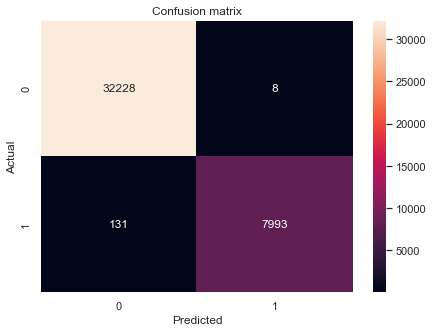

________________________________________________________________________________
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     32236
         1.0       1.00      0.98      0.99      8124

    accuracy                           1.00     40360
   macro avg       1.00      0.99      0.99     40360
weighted avg       1.00      1.00      1.00     40360

Information:
Precision: Percentage of correct positive predictions relative to total positive predictions
Recall: Percentage of correct positive predictions relative to total actual positives.
F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.
________________________________________________________________________________


In [14]:
# Scale Test Samples
X_test_scaled = scaler.transform(X_test)

# Predict in-sample values
y_pred = lr.predict(X_test_scaled)

# Plot Confusion matrics
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Heatmap plot settings
plt.figure(figsize=(7,5))
plt.title("Confusion matrix")
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot classification report
print(80 * "_")
print(classification_report(y_true=y_test, y_pred=y_pred))
print("Information:")
print("Precision: Percentage of correct positive predictions relative to total positive predictions")
print("Recall: Percentage of correct positive predictions relative to total actual positives.")
print("F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.")
print(80 * "_")

In [15]:
# Get Probability Predictions
pred_proba = pd.DataFrame(lr.predict_proba(X_test_scaled), columns=["P(y=0|x)", "P(y=1|x)"])
# Round to 5 decimal places
pred_proba = pred_proba.round(5)

pred_proba["y_pred"] = y_pred
pred_proba["y_actual"] = y_test.values

pred_proba.head(10)

,P(y=0|x),P(y=1|x),y_pred,y_actual
0,0.99235,0.00765,0.0,0.0
1,0.00000,1.00000,1.0,1.0
2,1.00000,0.00000,0.0,0.0
3,0.99271,0.00729,0.0,0.0
4,0.99529,0.00471,0.0,0.0
5,0.00000,1.00000,1.0,1.0
6,0.99993,0.00007,0.0,0.0
7,0.92195,0.07805,0.0,0.0
8,0.99995,0.00005,0.0,0.0
9,0.00000,1.00000,1.0,1.0
